<a href="https://colab.research.google.com/github/Ratnadeep2007/Meta_SP_Forecasting/blob/main/Meta_sp_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import LSTM,Dense,SimpleRNN, GRU, Bidirectional, Dropout
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# The start date and end date for selecting the data
start_date = dt.datetime(2018,1,1)
end_date = dt.datetime(2023,1,1)

#loading the Meta stock data from yahoo finance
data = yf.download("META",start_date,end_date)
pd.set_option('display.max_rows',6)
pd.set_option('display.max_columns',5)
print(data)

[*********************100%%**********************]  1 of 1 completed

                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2018-01-02  177.679993  181.580002  ...  181.419998  18151900
2018-01-03  181.880005  184.779999  ...  184.669998  16886600
2018-01-04  184.899994  186.210007  ...  184.330002  13880900
...                ...         ...  ...         ...       ...
2022-12-28  116.250000  118.150002  ...  115.620003  19612500
2022-12-29  116.400002  121.029999  ...  120.260002  22366200
2022-12-30  118.160004  120.419998  ...  120.339996  19583800

[1259 rows x 6 columns]


In [ ]:
# split the data in the ratio of 80:20
train_data_len = math.ceil(len(data)*0.8)
print(train_data_len)

# for training and testing
train_data = data[:train_data_len].iloc[:,:1]
test_data = data[train_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

1008
(1008, 1) (251, 1)


In [ ]:
# select the open price of the Meta Stock for training
dataset_train = train_data.Open.values

# reshape the data into 2D array
dataset_train = np.reshape(dataset_train,(-1,1))
dataset_train.shape

(1008, 1)

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))

# scaling the data
scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

[[0.21107586]
 [0.22731846]
 [0.23899759]
 [0.24166602]
 [0.24789233]]


In [ ]:
# select the open price of the Meta Stock for testing
dataset_test = test_data.Open.values

#reshape the data into 2D array
dataset_test = np.reshape(dataset_test,(-1,1))
dataset_test.shape

(251, 1)

In [ ]:
# scaling the data
scaled_test = scaler.fit_transform(dataset_test)
print(scaled_test[:5])

[[0.99339647]
 [1.        ]
 [0.97226549]
 [0.93144433]
 [0.97114491]]


In [ ]:
# For training data
X_train = []
Y_train = []
for i in range(50, len(scaled_train)):
  X_train.append(scaled_train[i-50:i, 0])
  Y_train.append(scaled_train[i,0])
  if i<51:
    print(X_train)
    print(Y_train)

[array([0.21107586, 0.22731846, 0.23899759, 0.24166602, 0.24789233,
       0.25369325, 0.24688686, 0.25253305, 0.21254544, 0.22584888,
       0.21718616, 0.21281618, 0.22333517, 0.2231418 , 0.24344499,
       0.25829531, 0.25079279, 0.25001935, 0.25388662, 0.24951658,
       0.25241704, 0.25183697, 0.26660993, 0.24684815, 0.21451779,
       0.23609713, 0.22395389, 0.19978342, 0.20867817, 0.20310928,
       0.1947173 , 0.2219816 , 0.21614204, 0.20368941, 0.20732466,
       0.2150205 , 0.21966121, 0.23776009, 0.23725733, 0.22894271,
       0.21621934, 0.19409852, 0.20535231, 0.22693171, 0.21517522,
       0.23381546, 0.23516903, 0.2402738 , 0.24174338, 0.2301029 ])]
[0.23257795795347286]


In [ ]:
# reshape the data to fit into LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)

# reshaping the array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
Y_train = np.reshape(Y_train, (Y_train.shape[0],1))
print('X_train shape is:',X_train.shape)
print('Y_train shape is:', Y_train.shape)


X_train shape is: (958, 50, 1)
Y_train shape is: (958, 1)


In [ ]:
# For testing data
X_test = []
Y_test = []
for i in range(50, len(scaled_test)):
  X_test.append(scaled_test[i-50:i, 0])
  Y_test.append(scaled_test[i,0])

In [ ]:
# reshape the data to fit into LSTM
X_test, Y_test = np.array(X_test), np.array(Y_test)

# reshaping the array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
Y_test = np.reshape(Y_test, (Y_test.shape[0],1))
print('X_test shape is:',X_test.shape)
print('Y_test shape is:', Y_test.shape)

X_test shape is: (201, 50, 1)
Y_test shape is: (201, 1)


In [ ]:
# Build the model
model_rnn = Sequential()

#add the RNN layers
model_rnn.add(SimpleRNN(units = 50, activation = 'tanh', return_sequences= True, input_shape=(50,1)))
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(units = 50, activation = 'tanh', return_sequences= True))
model_rnn.add(SimpleRNN(units = 50, activation = 'tanh', return_sequences= True))
model_rnn.add(SimpleRNN(units = 50))

# add neural network for output
model_rnn.add(Dense(units = 1, activation='linear'))
model_rnn.add(Dense(units = 1, activation='linear'))

# compile RNN model
model_rnn.compile(optimizer='adam', loss = 'mean_squared_error')

# fit the model
model_rnn.fit(X_train, Y_train, epochs =20)

Epoch 1/20
30/30 [==============================] - 7s 76ms/step - loss: 0.0363
Epoch 2/20
30/30 [==============================] - 2s 71ms/step - loss: 0.0042
Epoch 3/20
30/30 [==============================] - 1s 45ms/step - loss: 0.0030
Epoch 4/20
30/30 [==============================] - 1s 45ms/step - loss: 0.0027
Epoch 5/20
30/30 [==============================] - 1s 44ms/step - loss: 0.0022
Epoch 6/20
30/30 [==============================] - 1s 44ms/step - loss: 0.0020
Epoch 7/20
30/30 [==============================] - 1s 45ms/step - loss: 0.0024
Epoch 8/20
30/30 [==============================] - 1s 45ms/step - loss: 0.0023
Epoch 9/20
30/30 [==============================] - 1s 45ms/step - loss: 0.0020
Epoch 10/20
30/30 [==============================] - 2s 77ms/step - loss: 0.0019
Epoch 11/20
30/30 [==============================] - 2s 70ms/step - loss: 0.0022
Epoch 12/20
30/30 [==============================] - 1s 45ms/step - loss: 0.0017
Epoch 13/20
30/30 [==================

In [ ]:
# Build the model
model_lstm = Sequential()

#add the LSTM layers
model_lstm.add(LSTM(units = 50, activation = 'tanh', return_sequences= True, input_shape=(50,1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units = 50, activation = 'tanh', return_sequences= True))
model_lstm.add(LSTM(units = 50, activation = 'tanh', return_sequences= True))
model_lstm.add(LSTM(units = 50))

# add neural network for output
model_lstm.add(Dense(25, activation='tanh'))
model_lstm.add(Dense(units = 1, activation='linear'))

# compile LSTM model
model_lstm.compile(optimizer='adam', loss = 'mean_squared_error')

# fit the model
model_lstm.fit(X_train, Y_train, epochs =20)

Epoch 1/20
66/66 [==============================] - 14s 110ms/step - loss: 0.0128
Epoch 2/20
66/66 [==============================] - 6s 86ms/step - loss: 0.0010
Epoch 3/20
66/66 [==============================] - 9s 130ms/step - loss: 0.0010
Epoch 4/20
66/66 [==============================] - 6s 86ms/step - loss: 8.8534e-04
Epoch 5/20
66/66 [==============================] - 7s 110ms/step - loss: 9.6065e-04
Epoch 6/20
66/66 [==============================] - 6s 87ms/step - loss: 8.2317e-04
Epoch 7/20
66/66 [==============================] - 7s 109ms/step - loss: 7.5268e-04
Epoch 8/20
66/66 [==============================] - 6s 87ms/step - loss: 8.7856e-04
Epoch 9/20
66/66 [==============================] - 7s 104ms/step - loss: 0.0011
Epoch 10/20
66/66 [==============================] - 6s 91ms/step - loss: 7.5435e-04
Epoch 11/20
66/66 [==============================] - 6s 97ms/step - loss: 8.4298e-04
Epoch 12/20
66/66 [==============================] - 7s 100ms/step - loss: 7.5408e-0

In [ ]:
# Build the model
model_gru = Sequential()

#add the GRU layers
model_gru.add(GRU(units = 50, activation = 'tanh', return_sequences= True, input_shape=(50,1)))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units = 50, activation = 'tanh', return_sequences= True, input_shape=(50,1)))
model_gru.add(GRU(units = 50, activation = 'tanh', return_sequences= True, input_shape=(50,1)))
model_gru.add(GRU(units = 50, activation = 'tanh'))

# add neural network for output
model_gru.add(Dense(units = 1, activation='linear'))
model_rnn.add(Dense(units = 1, activation='linear'))

# compile GRU model
model_gru.compile(optimizer='adam', loss = 'mean_squared_error')

# fit the model
model_gru.fit(X_train, Y_train, epochs =20)

Epoch 1/20
30/30 [==============================] - 10s 93ms/step - loss: 0.0323
Epoch 2/20
30/30 [==============================] - 4s 142ms/step - loss: 0.0023
Epoch 3/20
30/30 [==============================] - 3s 92ms/step - loss: 0.0015
Epoch 4/20
30/30 [==============================] - 3s 91ms/step - loss: 0.0014
Epoch 5/20
30/30 [==============================] - 3s 93ms/step - loss: 0.0013
Epoch 6/20
30/30 [==============================] - 3s 117ms/step - loss: 0.0013
Epoch 7/20
30/30 [==============================] - 3s 113ms/step - loss: 0.0013
Epoch 8/20
30/30 [==============================] - 3s 92ms/step - loss: 0.0014
Epoch 9/20
30/30 [==============================] - 3s 93ms/step - loss: 0.0012
Epoch 10/20
30/30 [==============================] - 3s 113ms/step - loss: 0.0012
Epoch 11/20
30/30 [==============================] - 4s 133ms/step - loss: 0.0011
Epoch 12/20
30/30 [==============================] - 3s 92ms/step - loss: 0.0013
Epoch 13/20
30/30 [============

In [ ]:
# Prediction code
y_RNN = model_rnn.predict(X_test)
y_LSTM = model_lstm.predict(X_test)
y_GRU = model_gru.predict(X_test)

7/7 [==============================] - 0s 23ms/step


In [ ]:
# In this step values are brought back to un normalized form using inverse_transform
y_RNN_O = scaler.inverse_transform(y_RNN)
y_LSTM_O = scaler.inverse_transform(y_LSTM)
y_GRU_O = scaler.inverse_transform(y_GRU)

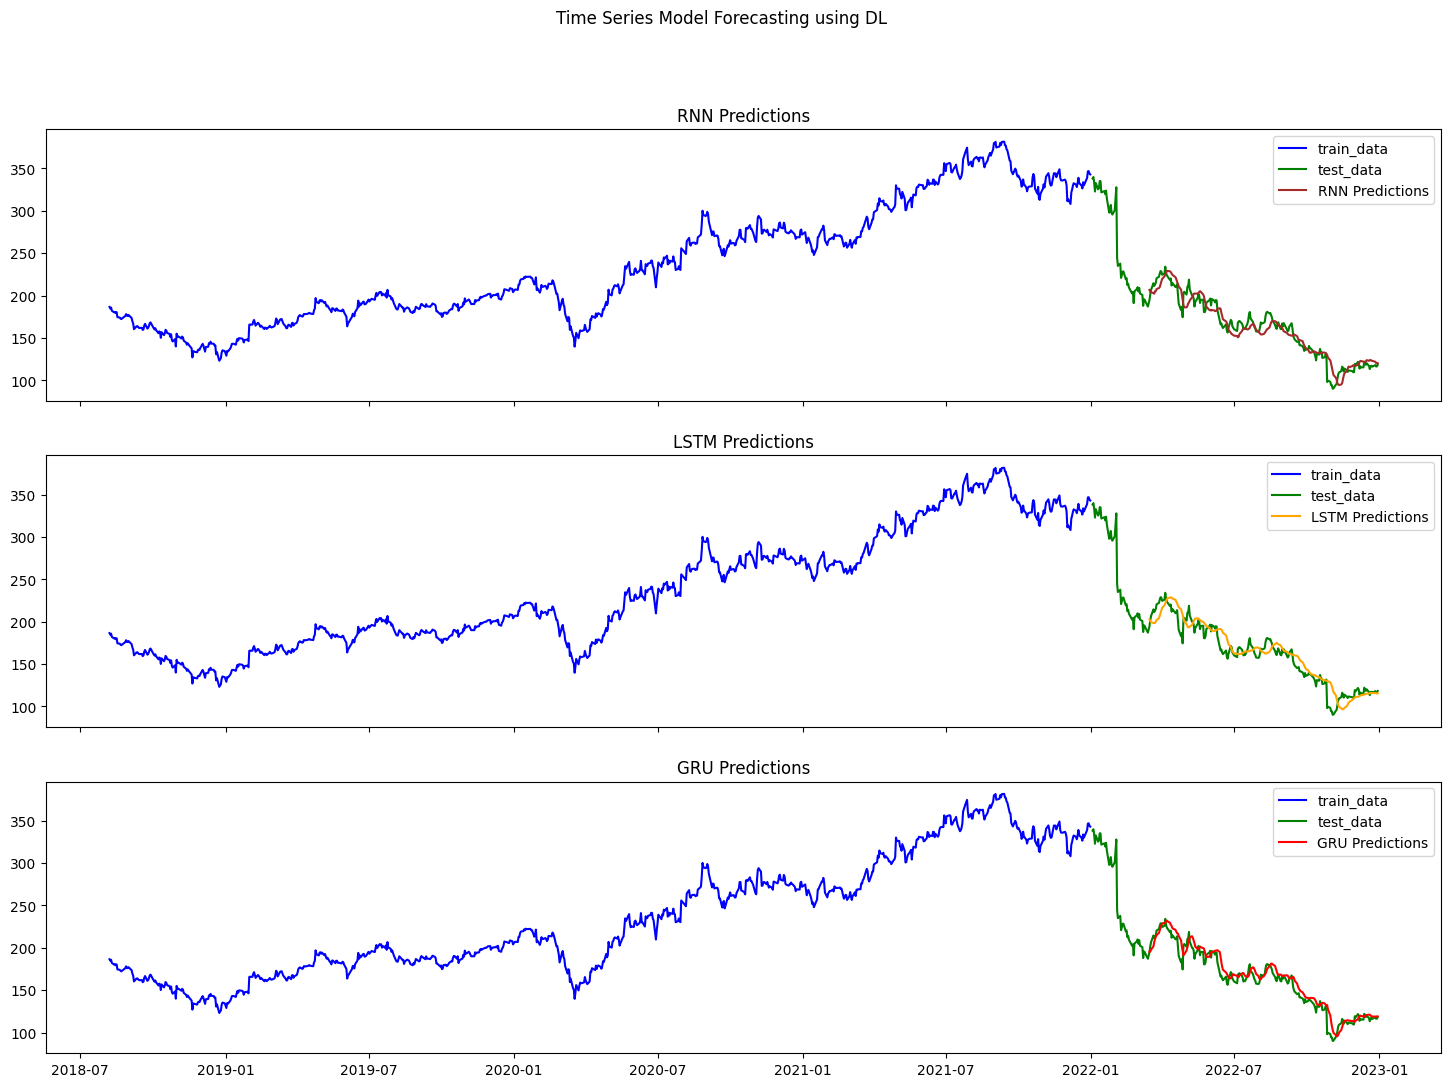

In [ ]:
fig, axs = plt.subplots(3, figsize = (18,12), sharex = True, sharey = True)
fig.suptitle('Time Series Model Forecasting using DL')

# plot the RNN Predictions
axs[0].plot(train_data.index[150:], train_data.Open[150:], label = 'train_data', color ='b')
axs[0].plot(test_data.index, test_data.Open, label = 'test_data', color='g')
axs[0].plot(test_data.index[50:], y_RNN_O, label = 'RNN Predictions', color='brown')
axs[0].legend()
axs[0].title.set_text('RNN Predictions')

# plot the LSTM Predictions
axs[1].plot(train_data.index[150:], train_data.Open[150:], label = 'train_data', color ='b')
axs[1].plot(test_data.index, test_data.Open, label = 'test_data', color='g')
axs[1].plot(test_data.index[50:], y_LSTM_O, label = 'LSTM Predictions', color='orange')
axs[1].legend()
axs[1].title.set_text('LSTM Predictions')

# plot the GRU Predictions
axs[2].plot(train_data.index[150:], train_data.Open[150:], label = 'train_data', color ='b')
axs[2].plot(test_data.index, test_data.Open, label = 'test_data', color='g')
axs[2].plot(test_data.index[50:], y_GRU_O, label = 'GRU Predictions', color='red')
axs[2].legend()
axs[2].title.set_text('GRU Predictions')